** 1.根据一个或多个键拆分pandas对象
2.计算分组摘要统计
3.对DataFrame列应用函数
4.应用组内转换或其他运算（规格化，线性回归，排名，选取子集）
5.透视表
6.分位数分析以及其他分组分析**

## GroupBy

In [8]:
from __future__ import division
from numpy.random import randn
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(12345)
plt.rc('figure', figsize=(10, 6))
from pandas import Series, DataFrame
import pandas as pd
np.set_printoptions(precision=4)
%matplotlib inline

In [9]:
pd.options.display.notebook_repr_html = False  #不适用html表达pandas数据

In [4]:
df = DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                'key2' : ['one', 'two', 'one', 'two', 'one'],
                'data1' : np.random.randn(5),
                'data2' : np.random.randn(5)})
df

      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
1  0.478943  0.092908    a  two
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two
4  1.965781  1.246435    a  one

- 按key1进行分组，并计算data1的平均值

In [4]:
df.groupby('key1').mean() #key2自动过滤掉，因为其不是数值型

         data1     data2
key1                    
a     0.746672  0.910916
b    -0.537585  0.525384

In [5]:
grouped=df['data1'].groupby(df['key1'])
grouped #获得是groupby的对象

In [6]:
grouped.mean()

key1
a    0.746672
b   -0.537585
Name: data1, dtype: float64

- 层次化索引

In [7]:
means=df['data1'].groupby([df['key1'],df['key2']]).mean()#注意groupby 内的[]
means

key1  key2
a     one     0.880536
      two     0.478943
b     one    -0.519439
      two    -0.555730
Name: data1, dtype: float64

In [8]:
means.unstack()

key2       one       two
key1                    
a     0.880536  0.478943
b    -0.519439 -0.555730

- 分组键亦可是等长的数组

In [9]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005    0.478943
            2006   -0.519439
Ohio        2005   -0.380219
            2006    1.965781
Name: data1, dtype: float64

- groupby().size() 返回一个含分组个数的Series

In [10]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### 对分组进行迭代

- Groupby 对象支持迭代，可以产生一组二元元祖

In [11]:
df

      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
1  0.478943  0.092908    a  two
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two
4  1.965781  1.246435    a  one

In [12]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
1  0.478943  0.092908    a  two
4  1.965781  1.246435    a  one
b
      data1     data2 key1 key2
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two


In [13]:
#对于多重键，元祖的第一个元素将会是由键值组成的元祖
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
4  1.965781  1.246435    a  one
('a', 'two')
      data1     data2 key1 key2
1  0.478943  0.092908    a  two
('b', 'one')
      data1     data2 key1 key2
2 -0.519439  0.281746    b  one
('b', 'two')
     data1     data2 key1 key2
3 -0.55573  0.769023    b  two


- 迭代数据片段形成字典

In [14]:
pieces=dict(list(df.groupby('key1')))
pieces['b']

      data1     data2 key1 key2
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two

- 默认axis=0进行分组，亦可更改

In [15]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

In [16]:
grouped = df.groupby(df.dtypes, axis=1)
dict(list(grouped))

{dtype('float64'):       data1     data2
 0 -0.204708  1.393406
 1  0.478943  0.092908
 2 -0.519439  0.281746
 3 -0.555730  0.769023
 4  1.965781  1.246435, dtype('O'):   key1 key2
 0    a  one
 1    a  two
 2    b  one
 3    b  two
 4    a  one}

### 选取一个或一组列

In [17]:
df.groupby('key1')['data1'].mean() #与下代码执行相同

key1
a    0.746672
b   -0.537585
Name: data1, dtype: float64

In [18]:
df['data1'].groupby(df['key1']).mean()

key1
a    0.746672
b   -0.537585
Name: data1, dtype: float64

In [19]:
df.groupby(['key1', 'key2'])[['data2']].mean()

              data2
key1 key2          
a    one   1.319920
     two   0.092908
b    one   0.281746
     two   0.769023

### 通过字典或Series进行分组

- 除数组以外，分组信息还可以其他形式存在

In [8]:
people = DataFrame(np.random.randn(5, 5),
                   columns=['a', 'b', 'c', 'd', 'e'],
                   index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

In [21]:
people

               a         b         c         d         e
Joe     1.007189 -1.296221  0.274992  0.228913  1.352917
Steve   0.886429 -2.001637 -0.371843  1.669025 -0.438570
Wes    -0.539741  0.476985  3.248944 -1.021228 -0.577087
Jim     0.124121  0.302614  0.523772  0.000940  1.343810
Travis -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

In [22]:
people.ix[2:3, ['b', 'c']] = np.nan # Add a few NA values
people

               a         b         c         d         e
Joe     1.007189 -1.296221  0.274992  0.228913  1.352917
Steve   0.886429 -2.001637 -0.371843  1.669025 -0.438570
Wes    -0.539741       NaN       NaN -1.021228 -0.577087
Jim     0.124121  0.302614  0.523772  0.000940  1.343810
Travis -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

- 假设已知列的分组关系，并希望根据分组计算列的总计

In [23]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}#分组关系 字典形式 

In [24]:
people.groupby(mapping,axis=1).sum()

            blue       red
Joe     0.503905  1.063885
Steve   1.297183 -1.553778
Wes    -1.021228 -1.116829
Jim     0.524712  1.770545
Travis -4.230992 -2.405455

In [25]:
#如果是Series形式
map_series = Series(mapping)
people.groupby(map_series, axis=1).count()

        blue  red
Joe        2    3
Steve      2    3
Wes        1    2
Jim        2    3
Travis     2    3

In [26]:
people.groupby(map_series, axis=1).size()

blue    2
red     3
dtype: int64

### 通过函数进行分组

- 人名长度进行分组

In [27]:
people.groupby(len).sum()

          a         b         c         d         e
3  0.591569 -0.993608  0.798764 -0.791374  2.119639
5  0.886429 -2.001637 -0.371843  1.669025 -0.438570
6 -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

- 混搭（函数与数组，列表，字典，Series）

In [28]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

              a         b         c         d         e
3 one -0.539741 -1.296221  0.274992 -1.021228 -0.577087
  two  0.124121  0.302614  0.523772  0.000940  1.343810
5 one  0.886429 -2.001637 -0.371843  1.669025 -0.438570
6 two -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

### 根据索引级别分组 (MutiIndex)

In [29]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],\
                                     [1, 3, 5, 1, 3]], names=['cty', 'tenor'])
columns

MultiIndex(levels=[['JP', 'US'], [1, 3, 5]],
           labels=[[1, 1, 1, 0, 0], [0, 1, 2, 0, 1]],
           names=['cty', 'tenor'])

In [30]:
hier_df = DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.560145 -1.265934  0.119827 -1.063512  0.332883
1     -2.359419 -0.199543 -1.541996 -0.970736 -1.307030
2      0.286350  0.377984 -0.753887  0.331286  1.349742
3      0.069877  0.246674 -0.011862  1.004812  1.327195

In [31]:
hier_df.groupby(level='cty', axis=1).count()

cty  JP  US
0     2   3
1     2   3
2     2   3
3     2   3

## 数据聚合

In [32]:
df

      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
1  0.478943  0.092908    a  two
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two
4  1.965781  1.246435    a  one

- 分位数 quantile

In [33]:
grouped=df.groupby('key1')
grouped['data1'].quantile(0.9)

key1
a    1.668413
b   -0.523068
Name: data1, dtype: float64

- 自定义聚合函数.agg(自定义函数)

In [34]:
def peak_to_peak(arr):
    return arr.max()-arr.min()

In [35]:
dict(list(grouped))

{'a':       data1     data2 key1 key2
 0 -0.204708  1.393406    a  one
 1  0.478943  0.092908    a  two
 4  1.965781  1.246435    a  one, 'b':       data1     data2 key1 key2
 2 -0.519439  0.281746    b  one
 3 -0.555730  0.769023    b  two}

In [36]:
grouped.agg(peak_to_peak)

         data1     data2
key1                    
a     2.170488  1.300498
b     0.036292  0.487276

- describe() 详细描述

In [37]:
grouped.describe()

               data1     data2
key1                          
a    count  3.000000  3.000000
     mean   0.746672  0.910916
     std    1.109736  0.712217
     min   -0.204708  0.092908
     25%    0.137118  0.669671
     50%    0.478943  1.246435
     75%    1.222362  1.319920
     max    1.965781  1.393406
b    count  2.000000  2.000000
     mean  -0.537585  0.525384
     std    0.025662  0.344556
     min   -0.555730  0.281746
     25%   -0.546657  0.403565
     50%   -0.537585  0.525384
     75%   -0.528512  0.647203
     max   -0.519439  0.769023

- 示例

In [21]:
tips = pd.read_csv('c/ch08/tips.csv')
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

   total_bill   tip     sex smoker  day    time  size   tip_pct
0       16.99  1.01  Female     No  Sun  Dinner     2  0.059447
1       10.34  1.66    Male     No  Sun  Dinner     3  0.160542
2       21.01  3.50    Male     No  Sun  Dinner     3  0.166587
3       23.68  3.31    Male     No  Sun  Dinner     2  0.139780
4       24.59  3.61  Female     No  Sun  Dinner     4  0.146808
5       25.29  4.71    Male     No  Sun  Dinner     4  0.186240

- 按照[smoke,sex]分列汇总[tip_pct]的平均值

In [42]:
tips['tip_pct'].groupby([tips['smoker'],tips['sex']]).mean()

smoker  sex   
No      Female    0.156921
        Male      0.160669
Yes     Female    0.182150
        Male      0.152771
Name: tip_pct, dtype: float64

In [44]:
grouped = tips.groupby(['sex', 'smoker'])
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

In [45]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

                   mean       std  peak_to_peak
sex    smoker                                  
Female No      0.156921  0.036421      0.195876
       Yes     0.182150  0.071595      0.360233
Male   No      0.160669  0.041849      0.220186
       Yes     0.152771  0.090588      0.674707

- (name,function)

In [46]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

                    foo       bar
sex    smoker                    
Female No      0.156921  0.036421
       Yes     0.182150  0.071595
Male   No      0.160669  0.041849
       Yes     0.152771  0.090588

- 对指定列使用指定通用函数

In [47]:
functions = ['count', 'mean', 'max']
result=grouped['tip_pct','total_bill'].agg(functions)
result

              tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

- 不同列使用不同函数 

In [48]:
#agg 运用字典
grouped.agg({'tip' : np.max, 'size' : 'sum'})

               size   tip
sex    smoker            
Female No       140   5.2
       Yes       74   6.5
Male   No       263   9.0
       Yes      150  10.0

In [49]:
grouped.mean()

               total_bill       tip      size   tip_pct
sex    smoker                                          
Female No       18.105185  2.773519  2.592593  0.156921
       Yes      17.977879  2.931515  2.242424  0.182150
Male   No       19.791237  3.113402  2.711340  0.160669
       Yes      22.284500  3.051167  2.500000  0.152771

In [50]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

              size   tip_pct                              
               sum       min       max      mean       std
sex    smoker                                             
Female No      140  0.056797  0.252672  0.156921  0.036421
       Yes      74  0.056433  0.416667  0.182150  0.071595
Male   No      263  0.071804  0.291990  0.160669  0.041849
       Yes     150  0.035638  0.710345  0.152771  0.090588

### 无索引形式返回聚合数据

In [51]:
tips.groupby(['sex', 'smoker'], as_index=False).mean()

      sex smoker  total_bill       tip      size   tip_pct
0  Female     No   18.105185  2.773519  2.592593  0.156921
1  Female    Yes   17.977879  2.931515  2.242424  0.182150
2    Male     No   19.791237  3.113402  2.711340  0.160669
3    Male    Yes   22.284500  3.051167  2.500000  0.152771

In [55]:
tips.groupby(['sex', 'smoker']).mean()

               total_bill       tip      size   tip_pct
sex    smoker                                          
Female No       18.105185  2.773519  2.592593  0.156921
       Yes      17.977879  2.931515  2.242424  0.182150
Male   No       19.791237  3.113402  2.711340  0.160669
       Yes      22.284500  3.051167  2.500000  0.152771

## 分组级运算和转换

In [52]:
df

      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
1  0.478943  0.092908    a  two
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two
4  1.965781  1.246435    a  one

- key1的均值添加的原数据

In [5]:
k1_mean=df.groupby('key1').mean().add_prefix('mean_')
k1_mean

      mean_data1  mean_data2
key1                        
a       0.746672    0.910916
b      -0.537585    0.525384

In [6]:
pd.merge(df,k1_mean,left_on='key1',right_index=True)
# 左列 left_on 右索引 right_index 作为连接

      data1     data2 key1 key2  mean_data1  mean_data2
0 -0.204708  1.393406    a  one    0.746672    0.910916
1  0.478943  0.092908    a  two    0.746672    0.910916
4  1.965781  1.246435    a  one    0.746672    0.910916
2 -0.519439  0.281746    b  one   -0.537585    0.525384
3 -0.555730  0.769023    b  two   -0.537585    0.525384

- **transform 函数应用到各个分组**  但有严格条件的特殊函数：可以广播的标准值（np.mean) 或者 相同大小的结果数组

In [9]:
key = ['one', 'two', 'one', 'two', 'one']
people.groupby(key).mean()

            a         b         c         d         e
one -0.082032 -0.550130  0.384568 -0.884358 -0.028309
two  0.505275 -0.849512  0.075965  0.834983  0.452620

In [10]:
people.groupby(key).transform(np.mean)# 广播功效

               a         b         c         d         e
Joe    -0.082032 -0.550130  0.384568 -0.884358 -0.028309
Steve   0.505275 -0.849512  0.075965  0.834983  0.452620
Wes    -0.082032 -0.550130  0.384568 -0.884358 -0.028309
Jim     0.505275 -0.849512  0.075965  0.834983  0.452620
Travis -0.082032 -0.550130  0.384568 -0.884358 -0.028309

- 从各组中减去平均值

In [69]:
def demean(arr):
    return arr-arr.mean()

In [72]:
people.groupby(key).transform(demean)

               a         b         c         d         e
Joe     1.089221 -0.232534  1.322612  1.113271  1.381226
Steve   0.381154 -1.152125 -0.447807  0.834043 -0.891190
Wes    -0.457709       NaN       NaN -0.136869 -0.548778
Jim    -0.381154  1.152125  0.447807 -0.834043  0.891190
Travis -0.631512  0.232534 -1.322612 -0.976402 -0.832448

### **apply 拆分-应用-合并**  apply传入的是函数

- 根据分组选出最高的5个tip_pct

In [13]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]
top(tips)

     total_bill   tip     sex smoker  day    time  size   tip_pct
183       23.17  6.50    Male    Yes  Sun  Dinner     4  0.280535
232       11.61  3.39    Male     No  Sat  Dinner     2  0.291990
67         3.07  1.00  Female    Yes  Sat  Dinner     1  0.325733
178        9.60  4.00  Female    Yes  Sun  Dinner     2  0.416667
172        7.25  5.15    Male    Yes  Sun  Dinner     2  0.710345

In [78]:
tips.sort_values(by=['tip_pct'])[-5:]

     total_bill   tip     sex smoker  day    time  size   tip_pct
183       23.17  6.50    Male    Yes  Sun  Dinner     4  0.280535
232       11.61  3.39    Male     No  Sat  Dinner     2  0.291990
67         3.07  1.00  Female    Yes  Sat  Dinner     1  0.325733
178        9.60  4.00  Female    Yes  Sun  Dinner     2  0.416667
172        7.25  5.15    Male    Yes  Sun  Dinner     2  0.710345

In [14]:
tips.groupby('smoker').apply(top)

            total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

In [81]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

                 total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6   
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5   
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3   
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4   

                  tip_pct  
smoker day                 
No     Fri  94   0.142857  
       Sat  212  0.186220  
       Sun  156  0.103799  
       Thur 142  0.121389  
Yes    Fri  95   0.117750  
       Sat  170  0.196812  
       Sun  182  0.077178  
       Thur 197  

- **禁止分组键**

In [85]:
tips.groupby('smoker', group_keys=False).apply(top,n=1)

     total_bill   tip   sex smoker  day    time  size   tip_pct
232       11.61  3.39  Male     No  Sat  Dinner     2  0.291990
172        7.25  5.15  Male    Yes  Sun  Dinner     2  0.710345

In [84]:
tips.groupby('smoker').apply(top,n=1)

            total_bill   tip   sex smoker  day    time  size   tip_pct
smoker                                                                
No     232       11.61  3.39  Male     No  Sat  Dinner     2  0.291990
Yes    172        7.25  5.15  Male    Yes  Sun  Dinner     2  0.710345

- **分位数和桶分析** cut  qcut  bucket quantile

In [86]:
frame = DataFrame({'data1': np.random.randn(1000),
                   'data2': np.random.randn(1000)})
factor = pd.cut(frame.data1, 4)
#由cut返回的对象可直接用于groupby  平均分为4等分
factor[:10]

0     (-1.23, 0.489]
1    (-2.956, -1.23]
2     (-1.23, 0.489]
3     (0.489, 2.208]
4     (-1.23, 0.489]
5     (0.489, 2.208]
6     (-1.23, 0.489]
7     (-1.23, 0.489]
8     (0.489, 2.208]
9     (0.489, 2.208]
Name: data1, dtype: category
Categories (4, object): [(-2.956, -1.23] < (-1.23, 0.489] < (0.489, 2.208] < (2.208, 3.928]]

- factor 分组运用在data2 求该区间 min  max count mean

In [87]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [89]:
grouped = frame.data2.groupby(factor)
grouped.apply(get_stats).unstack()

                 count       max      mean       min
data1                                               
(-2.956, -1.23]   95.0  1.670835 -0.039521 -3.399312
(-1.23, 0.489]   598.0  3.260383 -0.002051 -2.989741
(0.489, 2.208]   297.0  2.954439  0.081822 -3.745356
(2.208, 3.928]    10.0  1.765640  0.024750 -1.929776

In [94]:
grouping = pd.qcut(frame.data1, 10,labels=False) #labels 获取分为数编号
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

       count       max      mean       min
data1                                     
0      100.0  1.670835 -0.049902 -3.399312
1      100.0  2.628441  0.030989 -1.950098
2      100.0  2.527939 -0.067179 -2.925113
3      100.0  3.260383  0.065713 -2.315555
4      100.0  2.074345 -0.111653 -2.047939
5      100.0  2.184810  0.052130 -2.989741
6      100.0  2.458842 -0.021489 -2.223506
7      100.0  2.954439 -0.026459 -3.056990
8      100.0  2.735527  0.103406 -3.745356
9      100.0  2.377020  0.220122 -2.064111

### 示例：用特定分组的值填充缺失值

创建一列数组，指定缺失值，用平均数填充缺失值

In [96]:
s=Series(np.random.randn(6))
s[::2]=np.nan
s

0         NaN
1   -2.153545
2         NaN
3   -0.375842
4         NaN
5    0.981994
dtype: float64

In [97]:
s.fillna(s.mean())

0   -0.515798
1   -2.153545
2   -0.515798
3   -0.375842
4   -0.515798
5    0.981994
dtype: float64

In [98]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',\
          'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = Series(np.random.randn(8), index=states)
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio          1.105913
New York     -1.613716
Vermont            NaN
Florida       0.406510
Oregon        0.359244
Nevada             NaN
California   -1.691656
Idaho              NaN
dtype: float64

用分组East 和West的平均值填充缺失值

In [100]:
data.groupby(group_key).mean()

East   -0.033764
West   -0.666206
dtype: float64

In [102]:
fill_mean=lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)
#第一种用分组的平均值填充NA

Ohio          1.105913
New York     -1.613716
Vermont      -0.033764
Florida       0.406510
Oregon        0.359244
Nevada       -0.666206
California   -1.691656
Idaho        -0.666206
dtype: float64

In [103]:
fill_values = {'East': 0.5, 'West': -1}

用预设值填充NA

In [104]:
fill_func=lambda g: g.fillna(fill_values[g.name])
data.groupby(group_key).apply(fill_func)

Ohio          1.105913
New York     -1.613716
Vermont       0.500000
Florida       0.406510
Oregon        0.359244
Nevada       -1.000000
California   -1.691656
Idaho        -1.000000
dtype: float64

### 示例：随机采样和排列

In [121]:
# Hearts 红桃, Spades 黑桃, Clubs梅花 , Diamonds方片
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11))+[10]*3) * 4
base_names =(['A']+list(range(2, 11))+['J', 'K', 'Q'])
cards = []
for suit in ['H', 'S', 'C', 'D']:
    for num in base_names:
        cards.extend([str(num) + suit] )

deck = Series(card_val, index=cards)
deck[:13]
# range 需用list才能迭代，extend加是列表，append加单个元素

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

随机从上面牌抽出5张 np.random.permutation(总数）[抽取数]

In [122]:
def draw(deck, n=5):
    return deck.take(np.random.permutation(len(deck))[:n])
draw(deck)

2H     2
JD    10
KS    10
QH    10
JC    10
dtype: int64

每种花色随机抽取两张牌

In [133]:
get_suit = lambda card: card[-1]
get_suit

<function __main__.<lambda>>

In [135]:
deck.groupby(get_suit).apply(draw, n=2)
#groupby 中也可以用lambda

C  AC     1
   5C     5
D  5D     5
   6D     6
H  7H     7
   KH    10
S  5S     5
   2S     2
dtype: int64

In [136]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

3C    3
7C    7
9D    9
2D    2
9H    9
5H    5
9S    9
6S    6
dtype: int64

### 分组加权平均数和相关系数

In [15]:
df = DataFrame({'category': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                'data': np.random.randn(8),
                'weights': np.random.rand(8)})
df

  category      data   weights
0        a  0.560145  0.568394
1        a -1.265934  0.187818
2        a  0.119827  0.125842
3        a -1.063512  0.687596
4        b  0.332883  0.799607
5        b -2.359419  0.573537
6        b -0.199543  0.973230
7        b -1.541996  0.634054

In [16]:
grouped=df.groupby('category')
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_wavg)

category
a   -0.404912
b   -0.757927
dtype: float64

In [17]:
close_px = pd.read_csv('c/ch09/stock_px.csv', parse_dates=True, index_col=0)
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


In [18]:
close_px[-4:]

              AAPL   MSFT    XOM      SPX
2011-10-11  400.29  27.00  76.27  1195.54
2011-10-12  402.19  26.96  77.16  1207.25
2011-10-13  408.43  27.18  76.37  1203.66
2011-10-14  422.00  27.27  78.11  1224.58

计算一个由日收益率（通过百分数变化计算）与SPX之间的年度相关系数Dataframe

In [24]:
rets = close_px.pct_change().dropna()
rets[:10]
# pct_change()百分比计算

                AAPL      MSFT       XOM       SPX
2003-01-03  0.006757  0.001421  0.000684 -0.000484
2003-01-06  0.000000  0.017975  0.024624  0.022474
2003-01-07 -0.002685  0.019052 -0.033712 -0.006545
2003-01-08 -0.020188 -0.028272 -0.004145 -0.014086
2003-01-09  0.008242  0.029094  0.021159  0.019386
2003-01-10  0.002725  0.001824 -0.013927  0.000000
2003-01-13 -0.005435  0.008648 -0.004134 -0.001412
2003-01-14 -0.002732  0.010379  0.008993  0.005830
2003-01-15 -0.010959 -0.012506 -0.013713 -0.014426
2003-01-16  0.012465 -0.016282  0.004519 -0.003942

In [25]:
spx_corr = lambda x: x.corrwith(x['SPX'])

In [26]:
by_year=rets.groupby(lambda x : x.year)

In [29]:
by_year.apply(spx_corr)

          AAPL      MSFT       XOM  SPX
2003  0.541124  0.745174  0.661265  1.0
2004  0.374283  0.588531  0.557742  1.0
2005  0.467540  0.562374  0.631010  1.0
2006  0.428267  0.406126  0.518514  1.0
2007  0.508118  0.658770  0.786264  1.0
2008  0.681434  0.804626  0.828303  1.0
2009  0.707103  0.654902  0.797921  1.0
2010  0.710105  0.730118  0.839057  1.0
2011  0.691931  0.800996  0.859975  1.0

In [31]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))
#固定列的相关关系

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### 面向分组的线性回归

groupby 执行只要函数返回的pandas对象或标量都可以  最小二乘法                计算AAPL对SPX收益率的线性回归

In [32]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [33]:
by_year.apply(regress, 'AAPL', ['SPX'])

           SPX  intercept
2003  1.195406   0.000710
2004  1.363463   0.004201
2005  1.766415   0.003246
2006  1.645496   0.000080
2007  1.198761   0.003438
2008  0.968016  -0.001110
2009  0.879103   0.002954
2010  1.052608   0.001261
2011  0.806605   0.001514

## 透视表和交叉表

通过groupby;DataFrame 中可以用pivot_table方法；  pandas有piovt_table 函数

In [34]:
tips.head()

   total_bill   tip     sex smoker  day    time  size   tip_pct
0       16.99  1.01  Female     No  Sun  Dinner     2  0.059447
1       10.34  1.66    Male     No  Sun  Dinner     3  0.160542
2       21.01  3.50    Male     No  Sun  Dinner     3  0.166587
3       23.68  3.31    Male     No  Sun  Dinner     2  0.139780
4       24.59  3.61  Female     No  Sun  Dinner     4  0.146808

In [35]:
tips.groupby(['sex','smoker']).mean()

               total_bill       tip      size   tip_pct
sex    smoker                                          
Female No       18.105185  2.773519  2.592593  0.156921
       Yes      17.977879  2.931515  2.242424  0.182150
Male   No       19.791237  3.113402  2.711340  0.160669
       Yes      22.284500  3.051167  2.500000  0.152771

In [36]:
tips.pivot_table(index=['sex', 'smoker'])

                   size       tip   tip_pct  total_bill
sex    smoker                                          
Female No      2.592593  2.773519  0.156921   18.105185
       Yes     2.242424  2.931515  0.182150   17.977879
Male   No      2.711340  3.113402  0.160669   19.791237
       Yes     2.500000  3.051167  0.152771   22.284500

In [50]:
tips.groupby(['sex','day'])['tip_pct','size'].mean()

              tip_pct      size
sex    day                     
Female Fri   0.199388  2.111111
       Sat   0.156470  2.250000
       Sun   0.181569  2.944444
       Thur  0.157525  2.468750
Male   Fri   0.143385  2.100000
       Sat   0.151577  2.644068
       Sun   0.162344  2.810345
       Thur  0.165276  2.433333

聚合'tip_pct', 'size' 按照'sex', 'day' 分组，smoker放在列上

In [51]:
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'],columns='smoker')

              tip_pct                size          
smoker             No       Yes        No       Yes
sex    day                                         
Female Fri   0.165296  0.209129  2.500000  2.000000
       Sat   0.147993  0.163817  2.307692  2.200000
       Sun   0.165710  0.237075  3.071429  2.500000
       Thur  0.155971  0.163073  2.480000  2.428571
Male   Fri   0.138005  0.144730  2.000000  2.125000
       Sat   0.162132  0.139067  2.656250  2.629630
       Sun   0.158291  0.173964  2.883721  2.600000
       Thur  0.165706  0.164417  2.500000  2.300000

In [53]:
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'],\
                 columns='smoker', margins=True)
#默认margins=True 分类小计 All为平均值

              tip_pct                          size                    
smoker             No       Yes       All        No       Yes       All
sex    day                                                             
Female Fri   0.165296  0.209129  0.199388  2.500000  2.000000  2.111111
       Sat   0.147993  0.163817  0.156470  2.307692  2.200000  2.250000
       Sun   0.165710  0.237075  0.181569  3.071429  2.500000  2.944444
       Thur  0.155971  0.163073  0.157525  2.480000  2.428571  2.468750
Male   Fri   0.138005  0.144730  0.143385  2.000000  2.125000  2.100000
       Sat   0.162132  0.139067  0.151577  2.656250  2.629630  2.644068
       Sun   0.158291  0.173964  0.162344  2.883721  2.600000  2.810345
       Thur  0.165706  0.164417  0.165276  2.500000  2.300000  2.433333
All          0.159328  0.163196  0.160803  2.668874  2.408602  2.569672

In [59]:
tips.pivot_table('tip_pct', index=['sex', 'smoker'], columns='day', \
                 aggfunc=len, margins=True)
# len 是序列的个数  count是列表某个出现次数

day             Fri   Sat   Sun  Thur    All
sex    smoker                               
Female No       2.0  13.0  14.0  25.0   54.0
       Yes      7.0  15.0   4.0   7.0   33.0
Male   No       2.0  32.0  43.0  20.0   97.0
       Yes      8.0  27.0  15.0  10.0   60.0
All            19.0  87.0  76.0  62.0  244.0

In [60]:
tips.pivot_table('size', index=['time', 'sex', 'smoker'],
                 columns='day', aggfunc='sum', fill_value=0)

day                   Fri  Sat  Sun  Thur
time   sex    smoker                     
Dinner Female No        2   30   43     2
              Yes       8   33   10     0
       Male   No        4   85  124     0
              Yes      12   71   39     0
Lunch  Female No        3    0    0    60
              Yes       6    0    0    17
       Male   No        0    0    0    50
              Yes       5    0    0    23

#### 交叉表

In [10]:
from io import StringIO
data = """\
Sample    Gender    Handedness
1    Female    Right-handed
2    Male    Left-handed
3    Female    Right-handed
4    Male    Right-handed
5    Male    Left-handed
6    Male    Right-handed
7    Female    Right-handed
8    Female    Left-handed
9    Male    Right-handed
10    Female    Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')
#此模块主要用于在内存缓冲区中读写数据。模块是用类编写的，
#只有一个StringIO类，所以它的可用方法都在类中
#匹配空白符一次或多次 \s+

In [11]:
data

   Sample  Gender    Handedness
0       1  Female  Right-handed
1       2    Male   Left-handed
2       3  Female  Right-handed
3       4    Male  Right-handed
4       5    Male   Left-handed
5       6    Male  Right-handed
6       7  Female  Right-handed
7       8  Female   Left-handed
8       9    Male  Right-handed
9      10  Female  Right-handed

性别和用手习惯对这段数据进行统计汇总

In [20]:
data.pivot_table(index=['Gender','Handedness'],aggfunc=len).unstack()

                Sample             
Handedness Left-handed Right-handed
Gender                             
Female               1            4
Male                 2            3

In [19]:
pd.crosstab(data.Gender, data.Handedness, margins=True)

Handedness  Left-handed  Right-handed  All
Gender                                    
Female                1             4    5
Male                  2             3    5
All                   3             7   10

In [22]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

####  2012联邦选举委员会数据

In [70]:
fec = pd.read_csv('c/ch09/P00000001-ALL.csv')
fec.info()

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 122.3+ MB


In [71]:
fec.ix[123456]
#df 切片[:] 选取多个数字  

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

获取候选人名单（cand_nm)

In [72]:
unique_cands = fec.cand_nm.unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [73]:
#说明党派关系
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

党派关系加入原表(map  filter  reduce  )

In [74]:
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [75]:
fec.cand_nm[123456:123461].map(parties) #map 映射

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [76]:
fec['party'] = fec.cand_nm.map(parties)

In [77]:
fec['party'].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

刷选出资额为正 且排名前2位候选人

In [78]:
fec.cand_nm.value_counts()

Obama, Barack                     593746
Paul, Ron                         143757
Romney, Mitt                      107229
Gingrich, Newt                     47679
Santorum, Rick                     46559
Cain, Herman                       20107
Perry, Rick                        13575
Bachmann, Michelle                 13140
Roemer, Charles E. 'Buddy' III      5920
Pawlenty, Timothy                   4555
Huntsman, Jon                       4156
Johnson, Gary Earl                  1234
McCotter, Thaddeus G                  74
Name: cand_nm, dtype: int64

In [79]:
(fec.contb_receipt_amt > 0).value_counts()

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

In [80]:
fec = fec[fec.contb_receipt_amt > 0]

In [82]:
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]


- 根据职业和雇主统计赞助信息

In [83]:
fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])[:5]

0    False
1    False
2    False
3    False
4    False
Name: cand_nm, dtype: bool

In [84]:
fec_mrbo.pivot_table(index=("contbr_occupation"))[:10]

                                     contb_receipt_amt  file_num
contbr_occupation                                               
   MIXED-MEDIA ARTIST / STORYTELLER         100.000000    756218
 AREA VICE PRESIDENT                        250.000000    756218
 RESEARCH ASSOCIATE                         100.000000    756218
 TEACHER                                    500.000000    756218
 THERAPIST                                 1300.000000    756218
-                                          2500.000000    756218
.NET PROGRAMMER                              34.357143    766192
07/13/1972                                   49.000000    785239
12K ADVOCATE                                150.000000    785239
13D                                          40.055556    774379

In [85]:
fec.contbr_occupation.value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

职业类型合并

In [86]:
occ_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
   'C.E.O.': 'CEO'
}

In [87]:
f = lambda x: occ_mapping.get(x, x) # dict.get 他允许没有映射的也可以通过，返回x
fec.contbr_occupation = fec.contbr_occupation.map(f)

In [88]:
#雇主类型合并
emp_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'SELF' : 'SELF-EMPLOYED',
   'SELF EMPLOYED' : 'SELF-EMPLOYED',
}

# If no mapping provided, return x
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

In [89]:
by_occupation = fec.pivot_table('contb_receipt_amt',index='contbr_occupation',\
                                columns='party', aggfunc='sum')

过滤掉出资额低于200万的职业

In [90]:
over_2mm=by_occupation[by_occupation.sum(1)>2000000]
over_2mm

party                 Democrat    Republican
contbr_occupation                           
ATTORNEY           11141982.97  7.477194e+06
CEO                 2074974.79  4.211041e+06
CONSULTANT          2459912.71  2.544725e+06
ENGINEER             951525.55  1.818374e+06
EXECUTIVE           1355161.05  4.138850e+06
HOMEMAKER           4248875.80  1.363428e+07
INVESTOR             884133.00  2.431769e+06
LAWYER              3160478.87  3.912243e+05
MANAGER              762883.22  1.444532e+06
NOT PROVIDED        4866973.96  2.056547e+07
OWNER               1001567.36  2.408287e+06
PHYSICIAN           3735124.94  3.594320e+06
PRESIDENT           1878509.95  4.720924e+06
PROFESSOR           2165071.08  2.967027e+05
REAL ESTATE          528902.09  1.625902e+06
RETIRED            25305116.38  2.356124e+07
SELF-EMPLOYED        672393.40  1.640253e+06

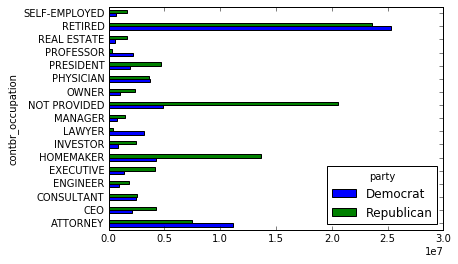

In [64]:
over_2mm.plot(kind='barh')

- 主要候选人哪个职业捐款多

In [110]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()

    # Order totals by key in descending order
    return totals.order(ascending=False)[:7]

In [100]:
fec_mrbo.groupby(['cand_nm']).sum()

               contb_receipt_amt      file_num
cand_nm                                       
Obama, Barack       1.358774e+08  456512611214
Romney, Mitt        8.833591e+07   81366834342

In [111]:
grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: order is deprecated, use sort_values(...)


cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

In [112]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: order is deprecated, use sort_values(...)


cand_nm        contbr_employer                       
Obama, Barack  RETIRED                                   22694358.85
               SELF-EMPLOYED                             17080985.96
               NOT EMPLOYED                               8586308.70
               INFORMATION REQUESTED                      5053480.37
               HOMEMAKER                                  2605408.54
               SELF                                       1076531.20
               SELF EMPLOYED                               469290.00
Romney, Mitt   INFORMATION REQUESTED PER BEST EFFORTS    12059527.24
               RETIRED                                   11506225.71
               HOMEMAKER                                  8147196.22
               SELF-EMPLOYED                              7409860.98
               STUDENT                                     496490.94
               CREDIT SUISSE                               281150.00
               MORGAN STANLEY                    

按出资额分组

In [124]:
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)
labels[:10]

411      (10, 100]
412    (100, 1000]
413    (100, 1000]
414      (10, 100]
415      (10, 100]
416      (10, 100]
417    (100, 1000]
418      (10, 100]
419    (100, 1000]
420      (10, 100]
Name: contb_receipt_amt, dtype: category
Categories (8, object): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

In [125]:
grouped = fec_mrbo.groupby(['cand_nm', labels])
grouped.size().unstack(0)

cand_nm              Obama, Barack  Romney, Mitt
contb_receipt_amt                               
(0, 1]                       493.0          77.0
(1, 10]                    40070.0        3681.0
(10, 100]                 372280.0       31853.0
(100, 1000]               153991.0       43357.0
(1000, 10000]              22284.0       26186.0
(10000, 100000]                2.0           1.0
(100000, 1000000]              3.0           NaN
(1000000, 10000000]            4.0           NaN

In [128]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
bucket_sums

cand_nm              Obama, Barack  Romney, Mitt
contb_receipt_amt                               
(0, 1]                      318.24         77.00
(1, 10]                  337267.62      29819.66
(10, 100]              20288981.41    1987783.76
(100, 1000]            54798531.46   22363381.69
(1000, 10000]          51753705.67   63942145.42
(10000, 100000]           59100.00      12700.00
(100000, 1000000]       1490683.08           NaN
(1000000, 10000000]     7148839.76           NaN

In [117]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)
normed_sums

cand_nm              Obama, Barack  Romney, Mitt
contb_receipt_amt                               
(0, 1]                    0.805182      0.194818
(1, 10]                   0.918767      0.081233
(10, 100]                 0.910769      0.089231
(100, 1000]               0.710176      0.289824
(1000, 10000]             0.447326      0.552674
(10000, 100000]           0.823120      0.176880
(100000, 1000000]         1.000000           NaN
(1000000, 10000000]       1.000000           NaN

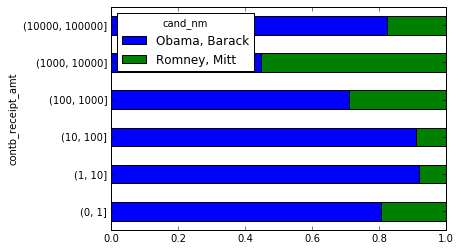

In [118]:
normed_sums[:-2].plot(kind='barh', stacked=True)

In [119]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals = totals[totals.sum(1) > 100000]
totals[:10]

cand_nm    Obama, Barack  Romney, Mitt
contbr_st                             
AK             281840.15      86204.24
AL             543123.48     527303.51
AR             359247.28     105556.00
AZ            1506476.98    1888436.23
CA           23824984.24   11237636.60
CO            2132429.49    1506714.12
CT            2068291.26    3499475.45
DC            4373538.80    1025137.50
DE             336669.14      82712.00
FL            7318178.58    8338458.81

In [120]:
percent = totals.div(totals.sum(1), axis=0)
percent[:10]

cand_nm    Obama, Barack  Romney, Mitt
contbr_st                             
AK              0.765778      0.234222
AL              0.507390      0.492610
AR              0.772902      0.227098
AZ              0.443745      0.556255
CA              0.679498      0.320502
CO              0.585970      0.414030
CT              0.371476      0.628524
DC              0.810113      0.189887
DE              0.802776      0.197224
FL              0.467417      0.532583